In [81]:
import numpy as np
import neurokit2 as nk
from scipy import integrate
import pickle
import pandas as pd
import numpy as np

# acceleration
def acc(speed, time):
    return np.gradient(speed, time, edge_order=2)

# motion sickness dose value
def msdv_eq(speed, time):
    return np.sqrt(integrate.cumtrapz(acc(speed, time)**2, time, initial=0))

# peaks
def find_peaks(gsr):
    decomposed_eda = nk.eda_process(gsr, sampling_rate=4)[0]
    eda_interval = nk.eda_intervalrelated(decomposed_eda, sampling_rate=4)
    num_of_peaks = eda_interval["SCR_Peaks_N"]
    return sum(num_of_peaks)

# load data
data_path = './data/raw_data2020.p'
dataPoolfont_sizefont_size = pickle.load(open(data_path, "rb"))

num_of_samples = len(list(dataPoolfont_sizefont_size.keys()))
# num_of_samples = 1
num_of_interval = 30

figsize = (15, 10)

input_list = []
output_list = []

for j in range(num_of_samples):
    name = list(dataPoolfont_sizefont_size.keys())[j]
    one_sample = dataPoolfont_sizefont_size[name]
    time_speed = one_sample.Steam.rawSpeed.Time
    raw_speed = one_sample.Steam.rawSpeed.Speed
    GSR = one_sample.Empatica.GSR
    time_eda = one_sample.Empatica.GSR.Time
    one_sample_input = []
    one_sample_output = []
    
    # adjust time scale
    t = np.arange(0, 0.25*len(GSR), 0.25)
    t_difference = t[-1] - time_speed.iloc[-1]
    if t_difference >= 0:
        countTimeInZero = int(t_difference/0.25)
        timeBase = t[countTimeInZero]
        t -= timeBase
    GSR.E4_Time = t
    GSR = GSR.drop(GSR[GSR.E4_Time < 0].index)
    GSR.reset_index(drop=True, inplace=True)
    
    # Peaks
    # method = neurokit / biosppy
    decomposed_eda = nk.eda_process(GSR.GSR, sampling_rate=4)[0]
    step = int(len(GSR.GSR) / num_of_interval)
    peaks_list = []
    piece_gsr = []
    for i in range(0, len(GSR.GSR), step):
        if len(GSR.GSR[i: i+step]) < step:
            eda_interval = nk.eda_intervalrelated(decomposed_eda[i-step:], 
                                                  sampling_rate=4)
            peaks_list[-1] = eda_interval["SCR_Peaks_N"].values
            piece_gsr[-1] = decomposed_eda["EDA_Raw"][i-step:].values
            # piece_gsr[-1] = decomposed_eda["EDA_Phasic"][i-step:].values
        else:
            eda_interval = nk.eda_intervalrelated(decomposed_eda[i: i+step], 
                                                  sampling_rate=4)
            peaks_list.append(eda_interval["SCR_Peaks_N"].values)
            piece_gsr.append(decomposed_eda["EDA_Raw"][i: i+step].values)
            # piece_gsr.append(decomposed_eda["EDA_Phasic"][i: i+step].values)

    # MSDV
    msdv_list = []
    step = int(len(time_speed) / num_of_interval)
    speed_list = []
    for i in range(0, len(raw_speed), step):
        if len(raw_speed[i: i+step]) < step:
            speed_list[-1] = raw_speed[i-step:].values
            msdv_list[-1] = msdv_eq(raw_speed[i-step:], time_speed[i-step:])
        else:
            speed_list.append(raw_speed[i: i+step].values)
            msdv_list.append(msdv_eq(raw_speed[i: i+step], time_speed[i: i+step]))
    
    input_list.append([name, speed_list, piece_gsr]) # INPUT
    output_list.append([name, msdv_list, peaks_list]) # OUTPUT

merged_input_list = []
merged_output_list = []
for i in range(num_of_samples):
    # remove group name
    input_list[i][0] = input_list[i][0].split("group")[0]
    input_list[i][0] = input_list[i][0].split("gift")[0]
    output_list[i][0] = output_list[i][0].split("group")[0]
    output_list[i][0] = output_list[i][0].split("gift")[0]
# merge info
skip_step, pivot = 0, 0
for i in range(num_of_samples):
    name = input_list[pivot][0]
    tmp_speed = input_list[pivot][1]
    tmp_gsr = input_list[pivot][2]
    tmp_msdv = output_list[pivot][1]
    tmp_peaks = output_list[pivot][2]
    matched = False
    for j in range(pivot+1, num_of_samples, 1):
        if name == input_list[j][0]:
            tmp_speed = tmp_speed + input_list[j][1]
            tmp_gsr = tmp_gsr + input_list[j][2]
            tmp_msdv = tmp_msdv + output_list[j][1]
            tmp_peaks = tmp_peaks + output_list[j][2]
            skip_step = j
            matched = True
    merged_input_list.append([name, tmp_speed, tmp_gsr])
    merged_output_list.append([name, tmp_msdv, tmp_peaks])
    if matched:
        pivot = skip_step+1
    else:
        pivot += 1
    if pivot >= num_of_samples:
        break

# file_name = './peaks/data0_BingHan4.txt'
# with open(file_name, 'wb') as fp:
#     pickle.dump(merged_output_list[4][2], fp)

file_name = 'input.txt'
with open(file_name, 'wb') as fp:
    pickle.dump(merged_input_list, fp)

# 120 trails: 'BingHan'4, 'Cunbo'7, 'Guanzhi'12, 'Lingfeng'26, 'Minghui'31, 'Olaf'32,
#                'Qichen'34, 'Wenzhe'40, 'Xinrui'43, 'Zhilong'51, 'Zihan'52

index = 52
action, msdv, sickness_level = [], [], []
# bound = [speed, msdv, sickness_level(1), sickness_level(2), sickness_level(3)]
bound = [1, 0.8, 0.1, 2.5, 4]
for i in range(120):
    # speed <=> action
    if np.mean(merged_input_list[index][1][i]) < bound[0]:
        action.append(0)
    else:
        action.append(1)
    # msdv <=> reward 
    if np.mean(merged_output_list[index][1][i]) < bound[1]:
        msdv.append(0)
    else:
        msdv.append(1)
    # true sickness level
    average = np.mean(merged_input_list[index][2][i])
    if average <= bound[2]:
        sickness_level.append(0.1)
    elif bound[2] < average <= bound[3]:
        sickness_level.append(0.4)
    elif bound[3] < average <= bound[4]:
        sickness_level.append(0.6)
    else:
        sickness_level.append(0.9)
    
action = np.double(action)
msdv = np.double(msdv)
# save as .mat file
import scipy     
Data_0 = {'action': action, 'reward': msdv}
scipy.io.savemat('Data.mat', Data_0, oned_as='column')
Data = {"level": sickness_level}
scipy.io.savemat("Sickness_level.mat", Data, oned_as='row')



/Users/davidzhan/anaconda3/envs/ML1/lib/python3.11/site-packages/neurokit2/eda/eda_clean.py:105: NeuroKitWarning: EDA signal is sampled at very low frequency. Skipping filtering.
  warn(
/Users/davidzhan/anaconda3/envs/ML1/lib/python3.11/site-packages/neurokit2/eda/eda_intervalrelated.py:116: RuntimeWarning: Mean of empty slice
  output["SCR_Peaks_Amplitude_Mean"] = np.nanmean(data[peaks_idx]["SCR_Amplitude"].values)
/var/folders/gk/z87t1wqx4p300dbsfbpqs4tw0000gn/T/ipykernel_41309/4005744092.py:14: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  return np.sqrt(integrate.cumtrapz(acc(speed, time)**2, time, initial=0))
/Users/davidzhan/anaconda3/envs/ML1/lib/python3.11/site-packages/neurokit2/eda/eda_clean.py:105: NeuroKitWarning: EDA signal is sampled at very low frequency. Skipping filtering.
  warn(
/var/folders/gk/z87t1wqx4p300dbsfbpqs4tw0000gn/T/ipykernel_41309/4005744092.py:14: De

In [82]:
len(Data_0['action'])

120

In [83]:
df_output = pd.DataFrame(merged_output_list,columns=['tester', 'msdv', 'peaks'])
df_output

,tester,msdv,peaks
0,Andreas,"[[0.0, 10.235038632014964, 14.073332389627016,...","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [2...."
1,Anjela,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1...."
2,Anne,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[4.0], [7.0], [5.0], [4.0], [6.0], [4.0], [6...."
3,Aron,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0], [4.0], [5.0], [3.0], [5.0], [6.0], [3...."
4,BingHan,"[[0.0, 3.154252773752122, 3.7037348249875524, ...","[[2.0], [2.0], [1.0], [0.0], [2.0], [1.0], [1...."
5,Bowen,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[5.0], [5.0], [4.0], [4.0], [4.0], [6.0], [5...."
6,Chenyang,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[2.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1...."
7,Cunbo,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[4.0], [5.0], [5.0], [5.0], [6.0], [5.0], [6...."
8,Danfo,"[[0.0, 6.530872954118741, 7.6432728994553365, ...","[[0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [0...."
9,Emilio,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[3.0], [4.0], [7.0], [6.0], [7.0], [6.0], [6...."


In [84]:
len(df_output['msdv'][52])

120

In [85]:
# import tensorflow as tf
# from tensorflow.keras import layers, models, Input, Model, regularizers

# # 输入形状，假设每个输入是 20x20 的灰度图像
# input_shape = (20, 20, 1)

# # 第一张图像输入
# image_1 = Input(shape=input_shape, name="image_1")

# # 第二张图像输入
# image_2 = Input(shape=input_shape, name="image_2")

# # 辅助输入，用于调整损失或其他功能（可以根据需要修改）
# aux_input = Input(shape=(1,), name="aux_input")

# # 定义共享的卷积层，用于提取图像特征
# shared_retina = layers.Conv2D(filters=4, kernel_size=(4, 4), activation='relu', 
#                               kernel_regularizer=regularizers.l2(0.001))
# shared_retina2 = layers.Conv2D(filters=4, kernel_size=(3, 3), activation='relu')

# # 对第一张图像进行编码
# encoded_1 = shared_retina(image_1)
# encoded_1 = layers.MaxPooling2D(pool_size=(2, 2))(encoded_1)
# encoded_1 = layers.Flatten()(encoded_1)

# # 对第二张图像进行编码
# encoded_2 = shared_retina(image_2)
# encoded_2 = layers.MaxPooling2D(pool_size=(2, 2))(encoded_2)
# encoded_2 = layers.Flatten()(encoded_2)

# # 定义潜在空间维度
# latent_dim = 4

# # 均值和对数方差的层
# z_mean = layers.Dense(units=latent_dim, name="z_mean")
# z_log_var = layers.Dense(units=latent_dim, name="z_log_var")

# # 计算潜在空间向量
# z_mean1 = z_mean(encoded_1)
# z_log_var1 = z_log_var(encoded_1)

# z_mean2 = z_mean(encoded_2)
# z_log_var2 = z_log_var(encoded_2)

# # 定义采样函数
# def sampling(args):
#     z_mean, z_log_var = args
#     epsilon = tf.keras.backend.random_normal(shape=tf.shape(z_mean))
#     return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# # 采样潜在空间向量
# z1 = layers.Lambda(sampling, name="z1")([z_mean1, z_log_var1])
# z2 = layers.Lambda(sampling, name="z2")([z_mean2, z_log_var2])

# # 合并潜在空间表示
# z_combined = layers.Concatenate(axis=-1)([z1, z2])

# # 定义隐藏层来处理合并后的潜在表示
# hidden_layer = layers.Dense(units=10, activation='relu')(z_combined)

# # 最终输出：cyber sickness 程度预测
# cyber_sickness = layers.Dense(units=1, activation='sigmoid', name="cyber_sickness")(hidden_layer)

# # 构建模型
# model = Model(inputs=[image_1, image_2, aux_input], outputs=cyber_sickness)

# # 编译模型
# model.compile(
#     loss="binary_crossentropy",
#     optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
# )

# # 打印模型摘要
# model.summary()


In [86]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 加载数据
index = 52  # 使用给定的index
msdv_input = df_output['msdv'][index]  # 90xX 的数据
# reward_output = Data_0['reward']  # 120个整数
reward_output = Data['level']
aux_input_data = Data_0['action']  # 120个整数

# 对msdv_input进行padding，使所有样本的时间步长一致
padded_msdv_input = pad_sequences(msdv_input, padding='post')

# 将reward_output和aux_input_data转换为numpy数组并扩展为二维
reward_output = np.array(reward_output).reshape(-1, 1)
aux_input_data = np.array(aux_input_data).reshape(-1, 1)

# 检查数据形状
print(f"padded_msdv_input shape: {padded_msdv_input.shape}")
print(f"reward_output shape: {reward_output.shape}")
print(f"aux_input_data shape: {aux_input_data.shape}")

# 假设 X 已经根据具体数据定义
X = padded_msdv_input.shape[1]  # 假设X是从之前的代码中定义的长度

# 调整输入形状，使其具有3个维度： (batch_size, sequence_length, features)
padded_msdv_input = np.expand_dims(padded_msdv_input, axis=-1)  # 添加一个特征维度

# 输入形状
input_shape = padded_msdv_input.shape[1:]  # 取出除去样本数外的形状部分

# 主要输入
main_input = Input(shape=input_shape, name="main_input")

# 辅助输入
aux_input = Input(shape=(1,), name="aux_input")

padded_msdv_input shape: (120, 745)
reward_output shape: (120, 1)
aux_input_data shape: (120, 1)


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ main_input          │ (None, 745, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_32 (Conv1D)  │ (None, 743, 32)   │        128 │ main_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_22    │ (None, 371, 32)   │          0 │ conv1d_32[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_33 (Conv1D)  │ (None, 369, 64)   │      6,208 │ max_pooling1d_22… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_23    │ (None, 184, 64)   │          0 │ conv1d_33[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_13          │ (None, 11776)     │          0 │ max_pooling1d_23… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ aux_input           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_12      │ (None, 11777)     │          0 │ flatten_13[0][0], │
│ (Concatenate)       │                   │            │ aux_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 64)        │    753,792 │ concatenate_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 64)        │          0 │ dense_23[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 32)        │      2,080 │ dropout_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cyber_sickness      │ (None, 1)         │         33 │ dense_24[0][0]    │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 762,241 (2.91 MB)

 Trainable params: 762,241 (2.91 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.0000e+00 - loss: 0.1171 - val_accuracy: 0.0000e+00 - val_loss: 0.1379
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.0000e+00 - loss: 0.1134 - val_accuracy: 0.0000e+00 - val_loss: 0.1199
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.0000e+00 - loss: 0.1496 - val_accuracy: 0.0000e+00 - val_loss: 0.0943
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.0000e+00 - loss: 0.0963 - val_accuracy: 0.0000e+00 - val_loss: 0.0620
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.0000e+00 - loss: 0.1125 - val_accuracy: 0.0000e+00 - val_loss: 0.0422
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.0000e+00 - loss: 0.1226 - val_accuracy: 0.0000e+00 - val_loss: 0.0811
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.0000e+00 - loss: 0.0987 - val_accuracy: 0.0000e+00 - val_loss: 0.1028
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 

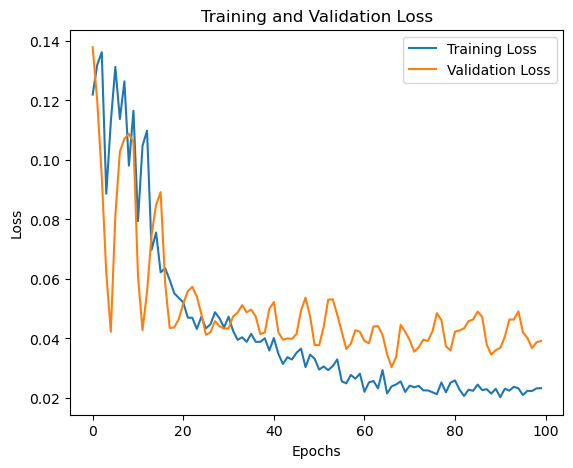

In [88]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model, regularizers
from tensorflow.keras.preprocessing.sequence import pad_sequences


# 定义卷积层和池化层，用于提取特征
shared_layer = layers.Conv1D(filters=32, kernel_size=3, activation='relu', 
                             kernel_regularizer=regularizers.l2(0.001))(main_input)
shared_layer = layers.MaxPooling1D(pool_size=2)(shared_layer)
shared_layer = layers.Conv1D(filters=64, kernel_size=3, activation='relu')(shared_layer)
shared_layer = layers.MaxPooling1D(pool_size=2)(shared_layer)
shared_layer = layers.Flatten()(shared_layer)

# 合并主要输入的特征表示和辅助输入
combined_input = layers.Concatenate(axis=-1)([shared_layer, aux_input])

# 定义隐藏层来处理合并后的表示
hidden_layer = layers.Dense(units=64, activation='relu')(combined_input)
hidden_layer = layers.Dropout(0.5)(hidden_layer)
hidden_layer = layers.Dense(units=32, activation='relu')(hidden_layer)

# 最终输出：cyber sickness 程度预测
cyber_sickness = layers.Dense(units=1, activation='sigmoid', name="cyber_sickness")(hidden_layer)

# 构建模型
model = Model(inputs=[main_input, aux_input], outputs=cyber_sickness)

# 编译模型
model.compile(
    loss="mean_squared_error",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# 打印模型摘要
model.summary()

# 训练模型并记录训练历史
history = model.fit([padded_msdv_input, aux_input_data], reward_output, 
                    epochs=100, batch_size=32, validation_split=0.2)

# 预测cyber sickness
predicted_sickness = model.predict([padded_msdv_input, aux_input_data])

# 打印预测结果
print(predicted_sickness)

# 计算MSE
mse = mean_squared_error(reward_output, predicted_sickness)
print(f"Mean Squared Error (MSE): {mse}")

# 绘制训练和验证损失曲线
plt.figure(figsize=(14, 5))

# 损失曲线
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# # 准确率曲线
# plt.subplot(1, 2, 2)
# plt.plot(history.history['accuracy'], label=｜｜'Training Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.title('Training and Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
plt.savefig('ANN/ANN2.png')
# 显示图像
plt.show()

In [55]:
from sklearn.metrics import mean_squared_error
# 计算预测值和真实值之间的MSE
mse = mean_squared_error(reward_output, predicted_sickness)

print(f"Mean Squared Error (MSE): {mse}")


Mean Squared Error (MSE): 0.04158685754546638


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


/Users/davidzhan/anaconda3/envs/ML1/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/davidzhan/anaconda3/envs/ML1/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


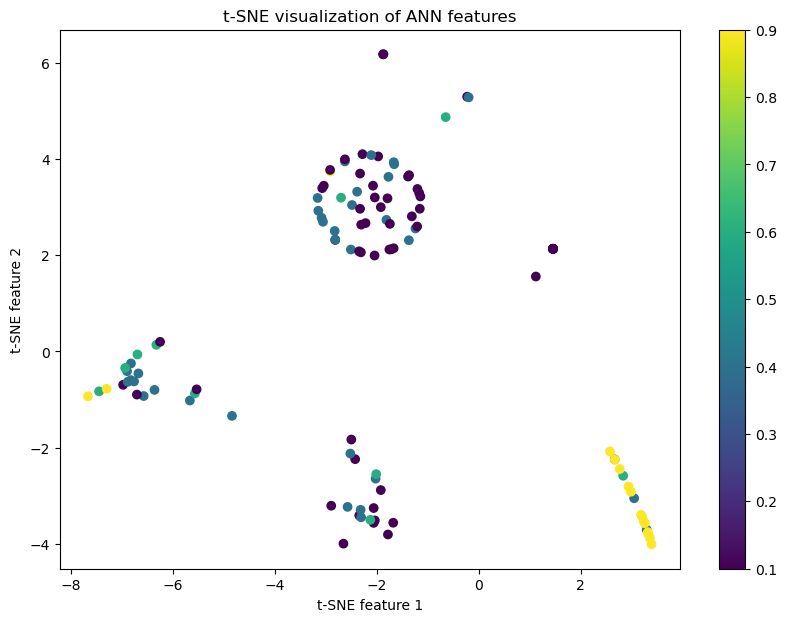

In [78]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 构建一个新的模型，以便从已有模型中提取隐藏层的输出
feature_extractor = Model(inputs=model.input, outputs=model.get_layer('dense_20').output)

# 提取特征
features = feature_extractor.predict([padded_msdv_input, aux_input_data])

# 使用t-SNE降维到2D
tsne = TSNE(n_components=2, random_state=42)
tsne_features = tsne.fit_transform(features)

# 可视化 t-SNE 结果
plt.figure(figsize=(10, 7))
plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=reward_output.flatten(), cmap='viridis')
plt.colorbar()
plt.title("t-SNE visualization of ANN features")
plt.xlabel("t-SNE feature 1")
plt.ylabel("t-SNE feature 2")
plt.show()


In [42]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model, regularizers

# 输入形状，假设每个输入是 90xX 的二维时间序列
input_shape = (90, 100)  # X是每个样本的时间步长

# 主要输入
main_input = Input(shape=input_shape, name="main_input")

# 辅助输入，用于调整损失或其他功能（可以根据需要修改）
aux_input = Input(shape=(1,), name="aux_input")

# 定义共享的卷积层，用于提取特征
shared_layer = layers.Conv1D(filters=32, kernel_size=3, activation='relu', 
                             kernel_regularizer=regularizers.l2(0.001))(main_input)
shared_layer = layers.MaxPooling1D(pool_size=2)(shared_layer)
shared_layer = layers.Conv1D(filters=64, kernel_size=3, activation='relu')(shared_layer)
shared_layer = layers.MaxPooling1D(pool_size=2)(shared_layer)
shared_layer = layers.Flatten()(shared_layer)

# 合并主要输入的特征表示和辅助输入
combined_input = layers.Concatenate(axis=-1)([shared_layer, aux_input])

# 定义隐藏层来处理合并后的表示
hidden_layer = layers.Dense(units=64, activation='relu')(combined_input)
hidden_layer = layers.Dropout(0.5)(hidden_layer)
hidden_layer = layers.Dense(units=32, activation='relu')(hidden_layer)

# 最终输出：cyber sickness 程度预测
cyber_sickness = layers.Dense(units=1, activation='sigmoid', name="cyber_sickness")(hidden_layer)

# 构建模型
model = Model(inputs=[main_input, aux_input], outputs=cyber_sickness)

# 编译模型
model.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
)

# 打印模型摘要
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ main_input          │ (None, 90, 100)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 88, 32)    │      9,632 │ main_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 44, 32)    │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 42, 64)    │      6,208 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 21, 64)    │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 1344)      │          0 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ aux_input           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 1345)      │          0 │ flatten_2[0][0],  │
│ (Concatenate)       │                   │            │ aux_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │     86,144 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,080 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cyber_sickness      │ (None, 1)         │         33 │ dense_2[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 104,097 (406.63 KB)

 Trainable params: 104,097 (406.63 KB)

 Non-trainable params: 0 (0.00 B)